# 412 HW1 Q1-Q7

## Q1. Download the U.S. GDP quarterly rates and the Standard & Poor's (SP) 500 quarterly returns. For both series, compute their descriptive statistics and their histograms. Are these two series contemporaneously correlated? Comment on your findings.

In [1]:
import pandas as pd
import requests
import numpy as np
from fredapi import Fred
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
import scipy.stats as stats
import rpy2

In [2]:
#  Downlaod the U.S. GDP quarterly rates

# Initialize the FRED API
fred = Fred(api_key='7feed5b2b0985a661ea3e9598905918f')

# Set the series ID for U.S. GDP quarterly rates data
series_id = 'GDPC1'

# Pull in the data using the fredapi library
gdp = fred.get_series(series_id)

# Add column titles
gdp = pd.DataFrame(gdp, columns=['GDP'])

# add a title for the index column
gdp = gdp.rename_axis('Date')

# add a column to calculate the GDP change rates
gdp['GDP_Change_Rates'] = gdp['GDP'].pct_change()

# Print the first few rows of the data
print(gdp.head())


                 GDP  GDP_Change_Rates
Date                                  
1947-01-01  2034.450               NaN
1947-04-01  2029.024         -0.002667
1947-07-01  2024.834         -0.002065
1947-10-01  2056.508          0.015643
1948-01-01  2087.442          0.015042


In [3]:
#  Downlaod the Standard & Poor's (SP) 500 quarterly returns
sp500 = yf.download("^GSPC")[["Adj Close"]]
sp500 = sp500.resample('QS').first()

#Slice the series datas so it has the same time period as gdp's
start = gdp.index[0]
end = gdp.index[-1]
sp500 = sp500[(sp500.index >= start) & (sp500.index <= end)]

# add a column to calculate the GDP change rates
sp500['SP500_Change_Rates'] = sp500['Adj Close'].pct_change()

# Print the first few rows of the data
print(sp500.head())

[*********************100%***********************]  1 of 1 completed
            Adj Close  SP500_Change_Rates
Date                                     
1947-01-01      15.20                 NaN
1947-04-01      15.23            0.001974
1947-07-01      15.46            0.015102
1947-10-01      15.16           -0.019405
1948-01-01      15.34            0.011873


In [4]:
# Compute the descriptive statistics

# GDP descriptive statistics
gdp_stats = gdp['GDP_Change_Rates'].describe()
print('U.S. GDP quarterly rates descriptive statistics:')
print(gdp_stats)

# SP500 descriptive statistics
sp500_stats = sp500['SP500_Change_Rates'].describe()
print('\nStandard & Poor\'s 500 quarterly returns descriptive statistics:')
print(sp500_stats)

U.S. GDP quarterly rates descriptive statistics:
count    303.000000
mean       0.007667
std        0.011481
min       -0.084843
25%        0.003032
50%        0.007540
75%        0.012580
max        0.078545
Name: GDP_Change_Rates, dtype: float64

Standard & Poor's 500 quarterly returns descriptive statistics:
count    303.000000
mean       0.021370
std        0.078004
min       -0.263078
25%       -0.024224
50%        0.027699
75%        0.072349
max        0.261227
Name: SP500_Change_Rates, dtype: float64


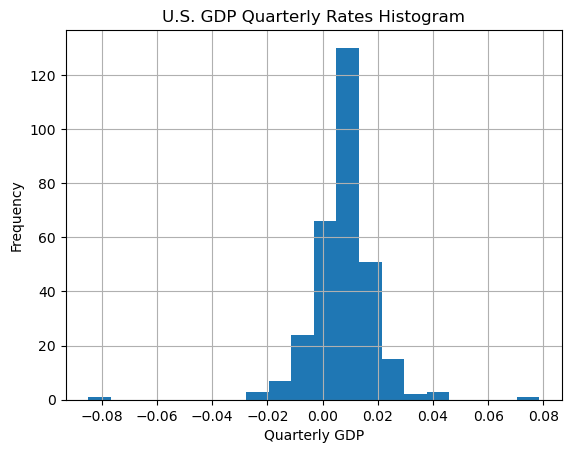

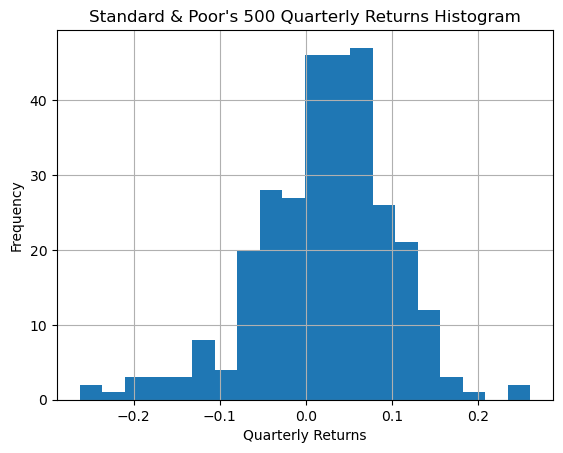

In [5]:
# Plot the histograms
gdp['GDP_Change_Rates'].hist(bins=20)
plt.title('U.S. GDP Quarterly Rates Histogram')
plt.xlabel('Quarterly GDP')
plt.ylabel('Frequency')
plt.show()

sp500['SP500_Change_Rates'].hist(bins=20)
plt.title('Standard & Poor\'s 500 Quarterly Returns Histogram')
plt.xlabel('Quarterly Returns')
plt.ylabel('Frequency')
plt.show()

In [6]:
# merge the two dataframes on their dates
merged_df = pd.merge(gdp, sp500, how='inner', on='Date')

# Subset the data to exclude the first row containing NA
merged_df = merged_df.iloc[1:]

merged_df.head()

,GDP,GDP_Change_Rates,Adj Close,SP500_Change_Rates
Date,,,,
1947-04-01,2029.024,-0.002667,15.23,0.001974
1947-07-01,2024.834,-0.002065,15.46,0.015102
1947-10-01,2056.508,0.015643,15.16,-0.019405
1948-01-01,2087.442,0.015042,15.34,0.011873
1948-04-01,2121.899,0.016507,15.12,-0.014342


In [7]:
model = smf.ols('GDP_Change_Rates ~ SP500_Change_Rates', data = merged_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       GDP_Change_Rates   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     35.46
Date:                Mon, 17 Apr 2023   Prob (F-statistic):           7.26e-09
Time:                        12:41:36   Log-Likelihood:                 940.97
No. Observations:                 303   AIC:                            -1878.
Df Residuals:                     301   BIC:                            -1871.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.0066      0.001     10.257      0.000       0.005       0.008
SP500_Change_Rates     0.0478      0.008      5.955      0.000       0.032       0.064
==============================================================================
Omnibus:                       92.873   Durbin-Watson:                   1.884
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1851.044
Skew:                          -0.682   Prob(JB):                         0.00
Kurtosis:                      15.031   Cond. No.                         12.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Since the p-value of 0.000 is statistically significant, the two series are contemporaneously correlated.


## Q2. The stock market is said to be a leading indicator for GDP growth. Because the stock market prices the expectations of future earnings, a bullish market may predict future economic growth and vice versa. Let Y, be GDP growth and X, be SP500 returns. (both series collecte at the quarterly frequency as in the previous exercise). Run OLS for the following models.

In [8]:
# merge the two dataframes on their dates
merged_df = pd.merge(gdp, sp500, how='inner', on='Date')
# create new columns for lagged values
merged_df['lag1_GDP_Change_Rates'] = merged_df['GDP_Change_Rates'].shift()
merged_df['lag1_SP500_Change_Rates'] = merged_df['SP500_Change_Rates'].shift()
merged_df['lag2_SP500_Change_Rates'] = merged_df['SP500_Change_Rates'].shift(2)
merged_df['lag3_SP500_Change_Rates'] = merged_df['SP500_Change_Rates'].shift(3)
merged_df['lag4_SP500_Change_Rates'] = merged_df['SP500_Change_Rates'].shift(4)

## a)

In [9]:
model_3a = smf.ols('GDP_Change_Rates ~ SP500_Change_Rates', data = merged_df).fit()
model_3a.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       GDP_Change_Rates   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     35.46
Date:                Mon, 17 Apr 2023   Prob (F-statistic):           7.26e-09
Time:                        12:41:36   Log-Likelihood:                 940.97
No. Observations:                 303   AIC:                            -1878.
Df Residuals:                     301   BIC:                            -1871.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.0066      0.001     10.257      0.000       0.005       0.008
SP500_Change_Rates     0.0478      0.008      5.955      0.000       0.032       0.064
==============================================================================
Omnibus:                       92.873   Durbin-Watson:                   1.884
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1851.044
Skew:                          -0.682   Prob(JB):                         0.00
Kurtosis:                      15.031   Cond. No.                         12.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## b)

In [10]:
model_3b = smf.ols('GDP_Change_Rates ~ lag1_SP500_Change_Rates', data = merged_df).fit()
model_3b.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       GDP_Change_Rates   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     6.551
Date:                Mon, 17 Apr 2023   Prob (F-statistic):             0.0110
Time:                        12:41:36   Log-Likelihood:                 924.21
No. Observations:                 302   AIC:                            -1844.
Df Residuals:                     300   BIC:                            -1837.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.0072      0.001     10.652      0.000       0.006       0.009
lag1_SP500_Change_Rates     0.0215      0.008      2.560      0.011       0.005       0.038
==============================================================================
Omnibus:                      123.600   Durbin-Watson:                   1.908
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5852.273
Skew:                          -0.847   Prob(JB):                         0.00
Kurtosis:                      24.499   Cond. No.                         12.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## c)

In [11]:
model_3c = smf.ols('GDP_Change_Rates ~ lag1_SP500_Change_Rates + lag2_SP500_Change_Rates + \
                   lag3_SP500_Change_Rates + lag4_SP500_Change_Rates', data = merged_df).fit()
model_3c.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       GDP_Change_Rates   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     4.070
Date:                Mon, 17 Apr 2023   Prob (F-statistic):            0.00316
Time:                        12:41:37   Log-Likelihood:                 919.17
No. Observations:                 299   AIC:                            -1828.
Df Residuals:                     294   BIC:                            -1810.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.0065      0.001      8.722      0.000       0.005       0.008
lag1_SP500_Change_Rates     0.0213      0.008      2.552      0.011       0.005       0.038
lag2_SP500_Change_Rates     0.0241      0.008      2.862      0.005       0.008       0.041
lag3_SP500_Change_Rates     0.0089      0.008      1.062      0.289      -0.008       0.026
lag4_SP500_Change_Rates    -0.0027      0.008     -0.315      0.753      -0.019       0.014
==============================================================================
Omnibus:                      124.720   Durbin-Watson:                   1.923
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5942.417
Skew:                          -0.877   Prob(JB):                         0.00
Kurtosis:                      24.769   Cond. No.                         13.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## d)

In [12]:
model_3d = smf.ols('GDP_Change_Rates ~ lag1_SP500_Change_Rates + lag2_SP500_Change_Rates + \
                   lag3_SP500_Change_Rates + lag4_SP500_Change_Rates + lag1_GDP_Change_Rates', data = merged_df).fit()
model_3d.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       GDP_Change_Rates   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     3.345
Date:                Mon, 17 Apr 2023   Prob (F-statistic):            0.00592
Time:                        12:41:37   Log-Likelihood:                 919.41
No. Observations:                 299   AIC:                            -1827.
Df Residuals:                     293   BIC:                            -1805.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.0063      0.001      7.663      0.000       0.005       0.008
lag1_SP500_Change_Rates     0.0192      0.009      2.171      0.031       0.002       0.037
lag2_SP500_Change_Rates     0.0232      0.009      2.727      0.007       0.006       0.040
lag3_SP500_Change_Rates     0.0079      0.009      0.916      0.360      -0.009       0.025
lag4_SP500_Change_Rates    -0.0030      0.008     -0.355      0.723      -0.020       0.014
lag1_GDP_Change_Rates       0.0426      0.062      0.688      0.492      -0.079       0.164
==============================================================================
Omnibus:                      114.889   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6286.807
Skew:                          -0.672   Prob(JB):                         0.00
Kurtosis:                      25.424   Cond. No.                         95.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## From the results above, it appears that model c has the highest R2 and Adj. R2 values among the four models, indicating that it explains the most variation in GDP_Change_Rates. Therefore, model c, which includes only the SP500_Change_Rates as the independent variable, may be the most preferable model among the four options for predicting GDP quarterly growth rates. 

## Q3. You have already downloaded some of the time series described in Chapter 1. Take the time series "unemployed persons" from the FRED database and the "number of people in poverty" from the U.S. Census Bureau. Calculate the growth rates for both series and compute their respective descriptive statistics. What is their correlation coefficient? Comment on your findings.

In [13]:
poverty = pd.read_excel('/Users/lianq/Downloads/Figure1_5_Poverty.xls', index_col = 0, parse_dates = True)

# change name of the index column
poverty = poverty.rename_axis('Date')

# Slice the df and only keep info we need
poverty = poverty.loc[:, ["Number in Poverty"]]

poverty.head()

,Number in Poverty
Date,
1959-01-01,39490
1960-01-01,39851
1961-01-01,39628
1962-01-01,38625
1963-01-01,36436


In [14]:
# add a column to calculate the GDP change rates
poverty['poverty_growth_rate'] = poverty['Number in Poverty'].pct_change()

#print the descriptive statistics
print(poverty['poverty_growth_rate'].describe())

count    47.000000
mean     -0.000336
std       0.052764
min      -0.140877
25%      -0.032861
50%      -0.009021
75%       0.035127
max       0.122737
Name: poverty_growth_rate, dtype: float64


In [15]:
# Retrieve the "unemployed persons" series
unemployed = fred.get_series('UNEMPLOY')

# resample to get data for the first day of each year
unemployed = unemployed.resample('AS').first()

# Convert the data to pandas DataFrame
unemployed = pd.DataFrame(unemployed, columns=['number_of_unemployed_persons'])

# change name of the index column
unemployed = unemployed.rename_axis('Date')

#Slice the series data so it has the same time period as poverty's
unemployed = unemployed[(unemployed.index >= poverty.index[0]) & (unemployed.index <= poverty.index[-1])]

unemployed.head()

,number_of_unemployed_persons
Date,
1959-01-01,4068.0
1960-01-01,3615.0
1961-01-01,4671.0
1962-01-01,4081.0
1963-01-01,4074.0


In [16]:
# add a column to calculate the GDP change rates
unemployed['unemployment_growth_rate'] = unemployed['number_of_unemployed_persons'].pct_change()

#print the descriptive statistics
print(unemployed['unemployment_growth_rate'].describe())

count    47.000000
mean      0.023983
std       0.171354
min      -0.219005
25%      -0.074544
50%      -0.017606
75%       0.064347
max       0.615202
Name: unemployment_growth_rate, dtype: float64


In [17]:
# Calculate the correlation coefficient and its p-value
correlation_coefficient, p_value = stats.pearsonr(poverty['poverty_growth_rate'][1:], unemployed['unemployment_growth_rate'][1:])

# Print the correlation coefficient and p-value
print('Correlation Coefficient:', correlation_coefficient)
print('P-value:', p_value)

Correlation Coefficient: 0.6034435266671503
P-value: 7.127722262598434e-06


## The Correlation Coefficient of 0.603 suggests a moderate positive correlation between 'poverty_growth_rate' and 'unemployment_growth_rate', and this correlation is statistically significant at a significance level of 0.05. 

## Q4. We would like to investigate whether changes in unemployment is one of the causes of changes in poverty changes. You may want to follow similar specifications as those in Exercise 3. For each model, comment on the R-squared and adjusted R-squared. Which model(s) do you prefer?

In [18]:
# merge the two dataframes on their dates
merged_4 = pd.merge(unemployed, poverty, how='inner', on='Date')

# create new columns for lagged values
merged_4['lag1_unemployment_growth_rate'] = merged_4['unemployment_growth_rate'].shift()
merged_4['lag2_unemployment_growth_rate'] = merged_4['unemployment_growth_rate'].shift(2)
merged_4['lag3_unemployment_growth_rate'] = merged_4['unemployment_growth_rate'].shift(3)
merged_4['lag3_unemployment_growth_rate'] = merged_4['unemployment_growth_rate'].shift(4)
merged_4['lag1_poverty_growth_rate'] = merged_4['poverty_growth_rate'].shift()

In [19]:
#  Model 1
model_4_1 = smf.ols('poverty_growth_rate ~ unemployment_growth_rate', data = merged_4).fit()

# Print the model summary
model_4_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     poverty_growth_rate   R-squared:                       0.364
Model:                             OLS   Adj. R-squared:                  0.350
Method:                  Least Squares   F-statistic:                     25.77
Date:                 Mon, 17 Apr 2023   Prob (F-statistic):           7.13e-06
Time:                         12:41:38   Log-Likelihood:                 82.726
No. Observations:                   47   AIC:                            -161.5
Df Residuals:                       45   BIC:                            -157.8
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -0.0048      0.006     -0.765      0.448      -0.017       0.008
unemployment_growth_rate     0.1858      0.037      5.076      0.000       0.112       0.260
==============================================================================
Omnibus:                        1.508   Durbin-Watson:                   1.091
Prob(Omnibus):                  0.470   Jarque-Bera (JB):                0.696
Skew:                          -0.073   Prob(JB):                        0.706
Kurtosis:                       3.578   Cond. No.                         5.90
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## In the OLS result, the R-squared value is 0.364, which means that approximately 36.4% of the variance in the dependent variable (poverty_growth_rate) is explained by the independent variable(s) in the model.  The adjusted R-squared value is 0.350, which is slightly lower than the R-squared value, indicating that the model may be slightly overfitting the data.

In [20]:
#  Model 2
model_4_2 = smf.ols('poverty_growth_rate ~ lag1_unemployment_growth_rate', data = merged_4).fit()

# Print the model summary
model_4_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     poverty_growth_rate   R-squared:                       0.008
Model:                             OLS   Adj. R-squared:                 -0.015
Method:                  Least Squares   F-statistic:                    0.3510
Date:                 Mon, 17 Apr 2023   Prob (F-statistic):              0.557
Time:                         12:41:38   Log-Likelihood:                 70.256
No. Observations:                   46   AIC:                            -136.5
Df Residuals:                       44   BIC:                            -132.9
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -0.0013      0.008     -0.159      0.875      -0.017       0.015
lag1_unemployment_growth_rate     0.0275      0.046      0.592      0.557      -0.066       0.121
==============================================================================
Omnibus:                        0.455   Durbin-Watson:                   1.020
Prob(Omnibus):                  0.797   Jarque-Bera (JB):                0.195
Skew:                           0.160   Prob(JB):                        0.907
Kurtosis:                       3.015   Cond. No.                         5.87
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## In the OLS result, the R-squared value is 0.008, which means that approximately 0.8% of the variance in the dependent variable (poverty_growth_rate) is explained by the independent variable(s) in the model. A low R-squared value indicates that the model does not have a good fit to the data and may not be able to explain much of the variability in the dependent variable.The adjusted R-squared value is -0.015, which is slightly negative, indicating that the model may not be a good fit to the data and may be overfitting. A negative adjusted R-squared value suggests that the model may not be explaining any more variance in the dependent variable than would be expected by random chance.

In [21]:
#  Model 3
model_4_3 = smf.ols('poverty_growth_rate ~ lag1_unemployment_growth_rate + \
                   lag2_unemployment_growth_rate + lag3_unemployment_growth_rate', data = merged_4).fit()

# Print the model summary
model_4_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     poverty_growth_rate   R-squared:                       0.046
Model:                             OLS   Adj. R-squared:                 -0.027
Method:                  Least Squares   F-statistic:                    0.6308
Date:                 Mon, 17 Apr 2023   Prob (F-statistic):              0.600
Time:                         12:41:38   Log-Likelihood:                 65.748
No. Observations:                   43   AIC:                            -123.5
Df Residuals:                       39   BIC:                            -116.5
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         0.0002      0.009      0.028      0.978      -0.017       0.018
lag1_unemployment_growth_rate     0.0459      0.052      0.886      0.381      -0.059       0.151
lag2_unemployment_growth_rate    -0.0445      0.051     -0.867      0.391      -0.148       0.059
lag3_unemployment_growth_rate     0.0380      0.049      0.769      0.446      -0.062       0.138
==============================================================================
Omnibus:                        0.015   Durbin-Watson:                   1.049
Prob(Omnibus):                  0.992   Jarque-Bera (JB):                0.114
Skew:                          -0.039   Prob(JB):                        0.944
Kurtosis:                       2.760   Cond. No.                         6.72
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## In the OLS result, the R-squared value is 0.046, which means that the model explains only 4.6% of the total variability in poverty_growth_rate. The adjusted R-squared value is -0.027, which means that the model is not a good fit for the data, as it has a negative value. It is important to note that a negative adjusted R-squared value is not meaningful and suggests that the model is likely not a good fit for the data.

In [22]:
#  Model 4
model_4_4 = smf.ols('poverty_growth_rate ~ unemployment_growth_rate + lag1_unemployment_growth_rate + \
                   lag2_unemployment_growth_rate + lag3_unemployment_growth_rate', data = merged_4).fit()

# Print the model summary
model_4_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     poverty_growth_rate   R-squared:                       0.410
Model:                             OLS   Adj. R-squared:                  0.348
Method:                  Least Squares   F-statistic:                     6.608
Date:                 Mon, 17 Apr 2023   Prob (F-statistic):           0.000387
Time:                         12:41:38   Log-Likelihood:                 76.082
No. Observations:                   43   AIC:                            -142.2
Df Residuals:                       38   BIC:                            -133.4
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -0.0040      0.007     -0.569      0.573      -0.018       0.010
unemployment_growth_rate          0.2047      0.042      4.842      0.000       0.119       0.290
lag1_unemployment_growth_rate    -0.0169      0.043     -0.392      0.698      -0.105       0.071
lag2_unemployment_growth_rate     0.0078      0.042      0.184      0.855      -0.078       0.093
lag3_unemployment_growth_rate     0.0206      0.040      0.522      0.605      -0.059       0.101
==============================================================================
Omnibus:                        2.054   Durbin-Watson:                   1.028
Prob(Omnibus):                  0.358   Jarque-Bera (JB):                1.130
Skew:                          -0.133   Prob(JB):                        0.568
Kurtosis:                       3.749   Cond. No.                         7.96
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##  In the OLS result, the R-squared (R^2) is 0.410, which means that approximately 41% of the total variation in the dependent variable (poverty_growth_rate) is explained by the independent variables. Adjusted R-squared is a modified version of R-squared that accounts for the number of independent variables and their effects on the model's goodness of fit. The adjusted R-squared value is 0.348, which means that approximately 34.8% of the total variation in the dependent variable is explained by the independent variables. Both values indicate that the model explains a moderate portion of the variability in the dependent variable.

## My preferrable model is model 4. From the results above, it appears that model 4 has the highest R2 and Adj. R2 values among the four models, indicating that it explains the most variation in poverty_growth_rate.

## Q5. Download monthly data on real personal consumption expenditures and real disposable personal income from the Federal Reserve Economic Database (FRED) of the St. Louis Fred (http://research.stlouisfred.org/fred2). Take a sample starting on 1959:01 and continuing to the most recent month.
## a. Calculate the growth rates of real consumption and disposable personal income and plot the data (simply calculate changes in natural-log). How do you compare the level of volatility on consumption growth with that of income growth? Can you explain it with your knowledge of macrioeconoics? (Hint: Consider the permanent income model)
## b. Regress consumption growth on disposable income growth. Interpret the estimated equation and discuss statistical significance.
## c. Add a lag of the growth in disposable income to the equation that you estimated in b. Based on your estimates, comment on the possibility of an adjustment lag in comsumption growth.

## a)

In [23]:
# Define the series IDs for the data you want to download
pce_id = 'PCEC96'  # Real personal consumption expenditures
dpi_id = 'DSPIC96'  # Real disposable personal income

# Download the data using the FRED API
pce_data = fred.get_series(pce_id)
dpi_data = fred.get_series(dpi_id)

# Convert the data to pandas DataFrame
pce = pd.DataFrame(pce_data, columns=['Real PCE'])
pce = pce[(pce.index >= '2002/01/01')]

dpi = pd.DataFrame(dpi_data, columns=['Real DPI'])
dpi = dpi[(dpi.index >= '2002/01/01')]

# add a title for the index columns
pce = pce.rename_axis('Date')
dpi = dpi.rename_axis('Date')

In [24]:
# Calculate the natural log of Real PCE and Real DPI
pce['Real_PCE_Log'] = np.log(pce['Real PCE'])
dpi['Real_DPI_Log'] = np.log(dpi['Real DPI'])

# Calculate the differences in natural log for Real PCE and Real DPI
pce['Real_PCE_Growth_Rate'] = pce['Real_PCE_Log'].diff()
dpi['Real_DPI_Growth_Rate'] = dpi['Real_DPI_Log'].diff()

# Print the resulting DataFrames with the growth rates
print("Growth Rates of Real Consumption Expenditures (Real PCE):")
print(pce['Real_PCE_Growth_Rate'])

print("\nGrowth Rates of Disposable Personal Income (Real DPI):")
print(dpi['Real_DPI_Growth_Rate'])

Growth Rates of Real Consumption Expenditures (Real PCE):
Date
2002-01-01         NaN
2002-02-01    0.003957
2002-03-01   -0.000210
2002-04-01    0.005330
2002-05-01   -0.003870
                ...   
2022-10-01    0.002647
2022-11-01   -0.004145
2022-12-01   -0.001931
2023-01-01    0.014426
2023-02-01   -0.001092
Name: Real_PCE_Growth_Rate, Length: 254, dtype: float64

Growth Rates of Disposable Personal Income (Real DPI):
Date
2002-01-01         NaN
2002-02-01    0.001476
2002-03-01    0.000672
2002-04-01    0.003393
2002-05-01    0.004059
                ...   
2022-10-01    0.006700
2022-11-01    0.003836
2022-12-01    0.002241
2023-01-01    0.014458
2023-02-01    0.001948
Name: Real_DPI_Growth_Rate, Length: 254, dtype: float64


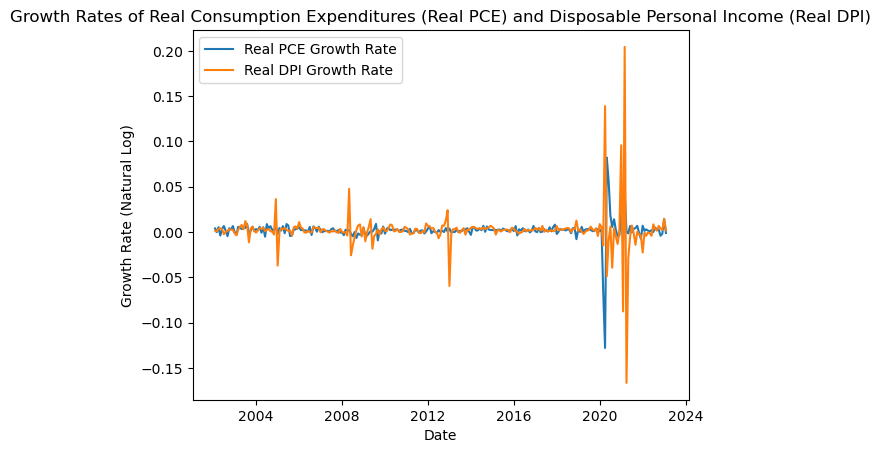

In [25]:
# Create a figure and axis
fig, ax = plt.subplots()

# Plot the Real PCE growth rate
ax.plot(pce.index, pce['Real_PCE_Growth_Rate'], label='Real PCE Growth Rate')

# Plot the Real DPI growth rate
ax.plot(dpi.index, dpi['Real_DPI_Growth_Rate'], label='Real DPI Growth Rate')

# Set the title and labels
ax.set_title('Growth Rates of Real Consumption Expenditures (Real PCE) and Disposable Personal Income (Real DPI)')
ax.set_xlabel('Date')
ax.set_ylabel('Growth Rate (Natural Log)')

# Add a legend
ax.legend()

# Show the plot
plt.show()

## From the plot above, we can see consumption growth is less volatile than income growth. I further confirm this by calculating the standard devisation of Real PCE growth rates and Real DPI growth rates as higher standard deviation indicates higher volatility.

In [26]:
# Calculate the standard deviation of Real PCE growth rates
pce_std = np.std(pce['Real_PCE_Growth_Rate'])

# Calculate the standard deviation of Real DPI growth rates
dpi_std = np.std(dpi['Real_DPI_Growth_Rate'])

# Compare the standard deviations
if pce_std < dpi_std:
    print("Consumption growth's std is less than income growth")
elif pce_std > dpi_std:
    print("Consumption growth' std is more than income growth")
else:
    print("Consumption growth and income growth have similar std")


Consumption growth's std is less than income growth


## As the standard deviation of the growth rate of personal consumption expenditures (PCE) is less than that of disposable personal income (DPI), it can be inferred that PCE is less volatile than DPI. This conclusion is in line with the Permanent Income Hypothesis (PIH) in macroeconomics, which suggests that individuals base their consumption decisions on their expected lifetime income rather than their current income. According to the PIH, consumption growth is expected to be less volatile than income growth, as individuals are likely to adjust their consumption less frequently in response to temporary changes in income and instead focus on long-term income expectations.

## b)

In [27]:
# Merge the 2 dfs
merged_5 = pd.merge(pce, dpi, how='inner', on='Date')

In [28]:
# OLS Model 
model_5b = smf.ols('Real_PCE_Growth_Rate ~ Real_DPI_Growth_Rate', data = merged_5).fit()

# Print the model summary
model_5b.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     Real_PCE_Growth_Rate   R-squared:                       0.017
Model:                              OLS   Adj. R-squared:                  0.013
Method:                   Least Squares   F-statistic:                     4.273
Date:                  Mon, 17 Apr 2023   Prob (F-statistic):             0.0398
Time:                          12:41:41   Log-Likelihood:                 763.19
No. Observations:                   253   AIC:                            -1522.
Df Residuals:                       251   BIC:                            -1515.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.0020      0.001      2.626      0.009       0.000       0.003
Real_DPI_Growth_Rate    -0.0694      0.034     -2.067      0.040      -0.136      -0.003
==============================================================================
Omnibus:                      237.823   Durbin-Watson:                   1.916
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            31720.268
Skew:                          -3.014   Prob(JB):                         0.00
Kurtosis:                      57.523   Cond. No.                         44.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## As shown above, the OLS equation is Real_PCE_Growth_Rate = 0.0020 - 0.0694 * Real_DPI_Growth_Rate. The coefficient of Real_DPI_Growth_Rate is -0.0694, which indicates that a one-unit increase in the growth rate of disposable personal income (DPI) is associated with a decrease of 0.0694 units in the growth rate of personal consumption expenditures (PCE). The intercept term is 0.0020, which represents the estimated growth rate of PCE when the growth rate of DPI is zero.
## The statistically significant p-value for the coefficient of Real_DPI_Growth_Rate (0.040) indicates that DPI growth rate is a statistically significant predictor of PCE growth rate at the 5% level of significance. 

## c)

In [29]:
# create new columns for lagged values
merged_5['lag1_Real_DPI_Growth_Rate'] = merged_5[['Real_DPI_Growth_Rate'] ].shift()

# OLS Model 
model_5c = smf.ols('Real_PCE_Growth_Rate ~ Real_DPI_Growth_Rate + lag1_Real_DPI_Growth_Rate', data = merged_5).fit()

# Print the model summary
model_5c.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     Real_PCE_Growth_Rate   R-squared:                       0.017
Model:                              OLS   Adj. R-squared:                  0.009
Method:                   Least Squares   F-statistic:                     2.124
Date:                  Mon, 17 Apr 2023   Prob (F-statistic):              0.122
Time:                          12:41:41   Log-Likelihood:                 759.69
No. Observations:                   252   AIC:                            -1513.
Df Residuals:                       249   BIC:                            -1503.
Df Model:                             2                                         
Covariance Type:              nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     0.0020      0.001      2.560      0.011       0.000       0.003
Real_DPI_Growth_Rate         -0.0674      0.040     -1.693      0.092      -0.146       0.011
lag1_Real_DPI_Growth_Rate     0.0038      0.040      0.095      0.924      -0.075       0.082
==============================================================================
Omnibus:                      238.217   Durbin-Watson:                   1.916
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            31535.483
Skew:                          -3.044   Prob(JB):                         0.00
Kurtosis:                      57.464   Cond. No.                         65.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## The estimates from the above OLS model do not suggest a statistically significant adjustment lag in consumption growth based on the lagged growth rate of disposable personal income. The coefficient for the lagged growth rate of disposable income is not statistically significant (p-value = 0.924), indicating that there is no strong evidence of an adjustment lag in consumption growth in response to changes in disposable income growth. 

## Q6. Visit again the website of the Federal Reserve Bank in St. Louis (http://research.stlouisfed.org) and download the following data:
## a. U.S. real GDP
## b. The exchage rate of the Japanese yen against the U.S. dollar.
## c. The 10-year U.S. Treasury constant maturity yield.
## d. The U.S. unemployment rate.
## For each data set, plot the time series, and write the exact definition, periodicity, and units. Judge whether the underlying stochastic process may be first and second order weakly stationary. Explain your reationale.

In [30]:
# Define the series IDs for the data you want to download
real_gdp_id = 'GDPC1'  # U.S. real GDP
exchange_rate_id = 'DTWEXB'  # Exchange rate of Japanese yen against U.S. dollar
treasury_yield_id = 'GS10'  # 10-year U.S. Treasury constant maturity yield
unemployment_rate_id = 'UNRATE'  # U.S. unemployment rate

# Download the data using the FRED API
real_gdp_data = fred.get_series(real_gdp_id)
exchange_rate_data = fred.get_series(exchange_rate_id)
treasury_yield_data = fred.get_series(treasury_yield_id)
unemployment_rate_data = fred.get_series(unemployment_rate_id)

# Convert the data to pandas DataFrame
real_gdp = pd.DataFrame(real_gdp_data, columns=['Real GDP'])
exchange_rate = pd.DataFrame(exchange_rate_data, columns=['Exchange Rate'])
treasury_yield = pd.DataFrame(treasury_yield_data, columns=['10-year Treasury Yield'])
unemployment_rate = pd.DataFrame(unemployment_rate_data, columns=['Unemployment Rate'])

# add a title for the index columns
real_gdp = real_gdp.rename_axis('Date')
exchange_rate = exchange_rate.rename_axis('Date')
treasury_yield = treasury_yield.rename_axis('Date')
unemployment_rate = unemployment_rate.rename_axis('Date')

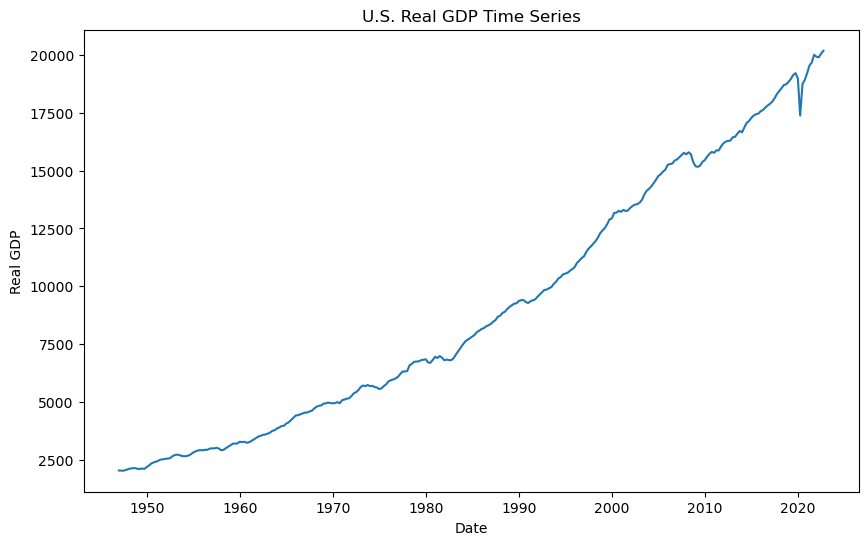

In [31]:
# Plot the time series of real GDP
plt.figure(figsize=(10, 6))
plt.plot(real_gdp['Real GDP'])
plt.xlabel('Date')
plt.ylabel('Real GDP')
plt.title('U.S. Real GDP Time Series')
plt.show()

## Exact Definition: Real Gross Domestic Product (GDP) is a measure of the total value of goods and services produced in an economy over a specific period of time, adjusted for inflation to remove the effects of price changes. It represents the output of an economy after accounting for changes in prices, and is considered a key indicator of economic growth and performance.

## Units of Real GDP: The units of Real GDP are typically expressed in a currency unit (e.g., million U.S. dollars for this dataset from Fred) and represent the total value of goods and services produced by an economy in that currency.

## Periodicity: The historical data for U.S. real GDP is reported on a quarterly basis, meaning it is measured every three months. 

## The underlying stochastic process of GDP series data is generally considered to be non-stationary with respect to first or second-order stationarity, as it can be influenced by various factors such as economic conditions, technological advancements, and policy changes. Additionally, as evident from the plot, the GDP series exhibits a clear increasing trend over time, further indicating the non-stationary nature of the data.

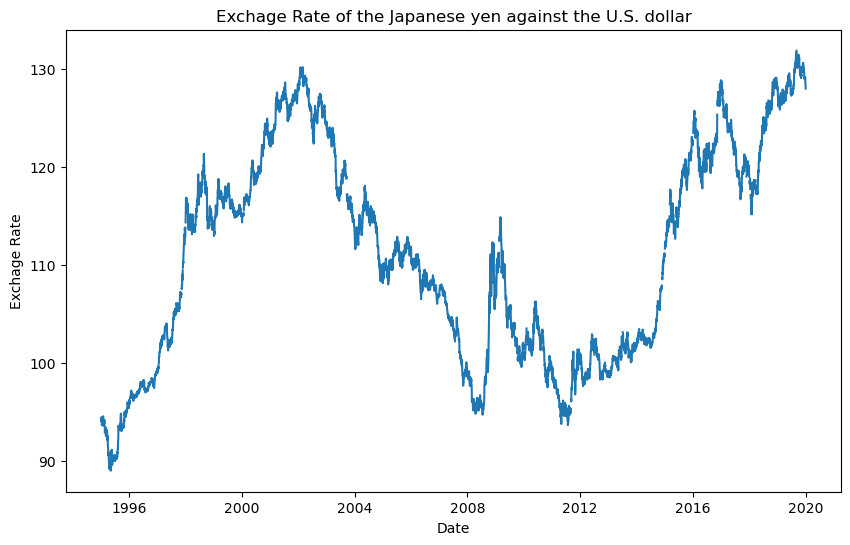

In [32]:
# Plot the time series of exchange rate
plt.figure(figsize=(10, 6))
plt.plot(exchange_rate['Exchange Rate'])
plt.xlabel('Date')
plt.ylabel('Exchage Rate')
plt.title('Exchage Rate of the Japanese yen against the U.S. dollar')
plt.show()

## Exact Definition: The exchange rate of the Japanese yen against the U.S. dollar is the value of one Japanese yen in terms of U.S. dollars. It represents the rate at which the two currencies can be exchanged in the foreign exchange market, reflecting the relative value of the yen compared to the U.S. dollar.

## Units of Exchange Rate: The exchange rate of the Japanese yen against the U.S. dollar is typically expressed as the amount of Japanese yen needed to exchange for one U.S. dollar. For example, a exchange rate of 110 yen per dollar means that it takes 110 yen to purchase one U.S. dollar.

## Periodicity: The exchange rate between the Japanese yen and the U.S. dollar is subject to constant fluctuations due to changes in supply and demand in the foreign exchange market, and it can change rapidly over time. Exchange rate data is typically reported in real-time or with varying time frequencies, depending on the data source and provider.

## Stationarity: The underlying stochastic process of the exchange rate between the Japanese yen and the U.S. dollar data is considered to be non-stationary with respect to first or second-order stationarity, as it tends to exhibit patterns of volatility and fluctuations in response to various economic, political, and global events. As evident from the plot above, the mean and variance of the exchange rate are not constant and change over time, further indicating the non-stationary nature of the data. 

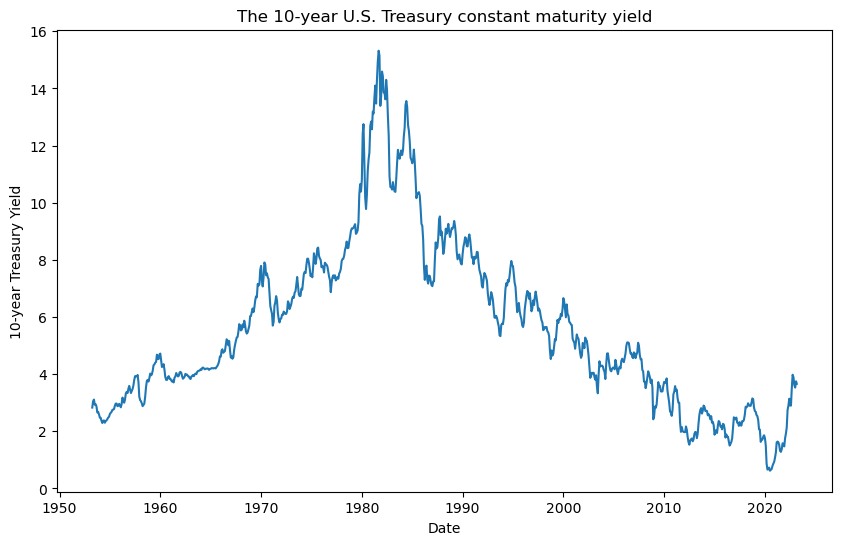

In [33]:
# Plot the time series of treasury yield
plt.figure(figsize=(10, 6))
plt.plot(treasury_yield['10-year Treasury Yield'])
plt.xlabel('Date')
plt.ylabel('10-year Treasury Yield')
plt.title('The 10-year U.S. Treasury constant maturity yield')
plt.show()

## Exact Definition: The 10-year U.S. Treasury constant maturity yield is a measure of the annualized yield on U.S. Treasury securities with a maturity of 10 years, expressed as a percentage. It represents the interest rate that investors would earn on their investment in these securities if held to maturity, and is considered an important benchmark for assessing the cost of borrowing and the overall health of the U.S. economy.

## Units of Yield: The 10-year U.S. Treasury constant maturity yield is typically expressed as a percentage per annum, representing the annual interest rate that would be earned on a 10-year investment in U.S. Treasury securities.

## Periodicity: The 10-year U.S. Treasury constant maturity yield is reported on a daily basis, reflecting the prevailing yield on U.S. Treasury securities with a 10-year maturity. It is updated regularly and can be accessed from various sources, such as financial news websites, economic data providers, and government agencies.

## Stationarity: The underlying stochastic process of the 10-year U.S. Treasury constant maturity yield is considered to be non-stationary with respect to first or second-order stationarity, as it can be influenced by various factors such as changes in interest rates, inflation expectations, economic conditions, and investor sentiment. As evident from the plot, the mean and variance of the yield data are not constant and change over time, further indicating the non-stationary nature of the series. 

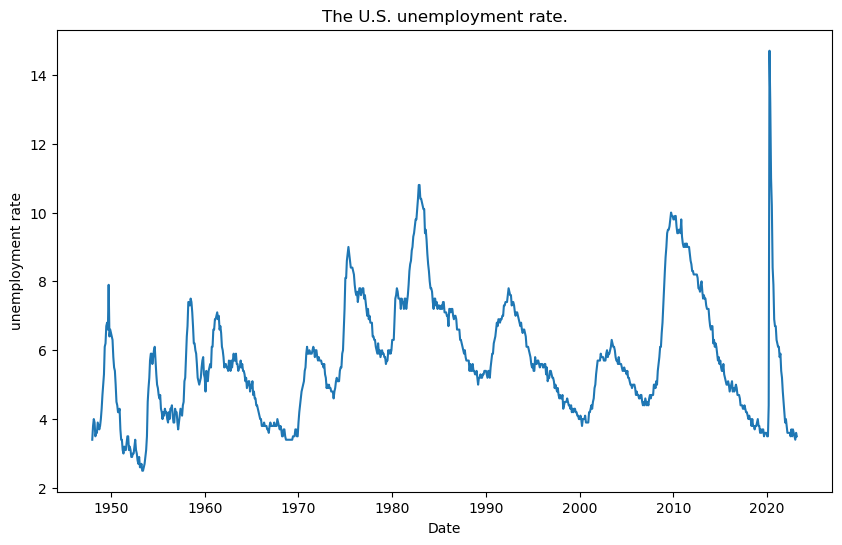

In [34]:
# Plot the time series of unemployment rate
plt.figure(figsize=(10, 6))
plt.plot(unemployment_rate['Unemployment Rate'])
plt.xlabel('Date')
plt.ylabel('unemployment rate')
plt.title('The U.S. unemployment rate.')
plt.show()

## Exact Definition: The U.S. unemployment rate is a measure of the percentage of the civilian labor force that is unemployed, meaning individuals who are actively seeking employment but are unable to find a job. It is calculated as the ratio of the number of unemployed individuals to the total civilian labor force, and is considered a key indicator of the health of the labor market and the overall state of the U.S. economy.

## Units of Unemployment Rate: The U.S. unemployment rate is typically expressed as a percentage, representing the proportion of the labor force that is unemployed. For example, an unemployment rate of 5% means that 5% of the labor force is unemployed.

## Periodicity: The U.S. unemployment rate is reported on a monthly basis by the U.S. Bureau of Labor Statistics (BLS), reflecting the state of the labor market in the preceding month. It is updated regularly and can be accessed from various sources, such as the BLS website, economic data providers, and government agencies.

## Stationarity: The underlying stochastic process of the U.S. unemployment rate is considered to be non-stationary with respect to first or second-order stationarity, as it can exhibit patterns of fluctuations over time in response to changes in economic conditions, labor market dynamics, and government policies. As evident from the plot above, the mean and variance of the unemployment rate are not constant and change over time, further indicating the non-stationary nature of the data. 

## Q7. The following table contains quarterly nominal GDP in U.S. (billions of dollars). Let Yt denote the GDP at time t and let yt = ln(yt)
## a. Plot the time series (Yt). Can the underlying stochastic process be weakly stationary of any order? Explain why or why not.
## b. Calculate the growth rate of nominal GDP by computing the percentage changes of the series, that is, g1t = 100 x(Yt - Yt-1)/Yt-1
## c. Plot the natural logarithm of the series (yt) and compare with part i., commenting on stationary and smoothness.
## d. Repeat part ii. by taking the first log-differences (in percentage), that is, g2t = 100x(yt - yt-1).
## e. Do you observe any significant differences between g1t and g2t computed in ii. and iv, respectively?

In [35]:
# Define the table data as lists
dates = ['1/1/2001', '4/1/2001', '7/1/2001', '10/1/2001', '1/1/2002', '4/1/2002', '7/1/2002', '10/1/2002',
         '1/1/2003', '4/1/2003', '7/1/2003', '10/1/2003', '1/1/2004', '4/1/2004', '7/1/2004', '10/1/2004']
gdps = ['10,021.5', '10,128.9', '10,135.1', '10,226.3', '10,338.2', '10,445.7', '10,546.5', '10,617.5',
        '10,744.6', '10,884.0', '11,116.7', '11,270.9', '11,472.6', '11,657.5', '11,814.9', '11,994.8']

# Create a dictionary from the lists
data = {'Date': dates, 'GDP': gdps}

# Convert the dictionary to a Pandas DataFrame
nominalGDP = pd.DataFrame(data)

# Convert 'Date' column to datetime type
nominalGDP['Date'] = pd.to_datetime(nominalGDP['Date'])

# Set 'Date' column as index
nominalGDP.set_index('Date', inplace=True)

# Convert 'GDP' column to float
nominalGDP['GDP'] = nominalGDP['GDP'].str.replace(',', '').astype(float)

# Display the DataFrame
print(nominalGDP)


                GDP
Date               
2001-01-01  10021.5
2001-04-01  10128.9
2001-07-01  10135.1
2001-10-01  10226.3
2002-01-01  10338.2
2002-04-01  10445.7
2002-07-01  10546.5
2002-10-01  10617.5
2003-01-01  10744.6
2003-04-01  10884.0
2003-07-01  11116.7
2003-10-01  11270.9
2004-01-01  11472.6
2004-04-01  11657.5
2004-07-01  11814.9
2004-10-01  11994.8


# a)

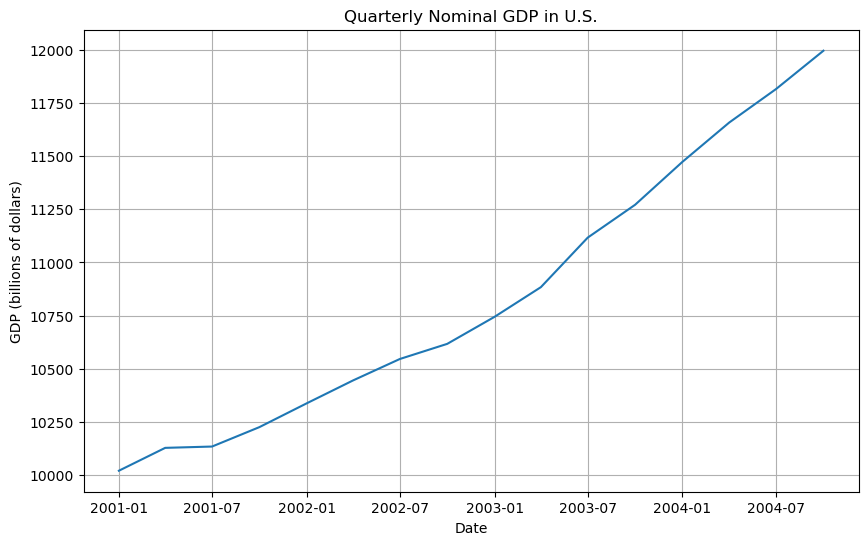

In [36]:
plt.figure(figsize=(10, 6))
plt.title('Quarterly Nominal GDP in U.S.')
plt.plot(nominalGDP['GDP'])
plt.xlabel('Date')
plt.ylabel('GDP (billions of dollars)')
plt.grid()

##  No, the underlying stochastic process cannot be weakly stationary of any order. A weakly stationary process has constant mean, constant variance, and autocovariance that only depends on the time lag. From the plot, we can see that the GDP time series has a clear increasing trend, which indicates a changing mean over time. Therefore, the underlying stochastic process of the GDP time series is not likely to be weakly stationary of any order, as it violates the condition of having a constant mean.

## b)

In [37]:
# create lag GDP column
nominalGDP['lag_GDP'] = nominalGDP['GDP'].shift()

In [38]:
# Calculate the growth rate of nominal GDP
nominalGDP['Growth_rate'] = 100*(nominalGDP['GDP'] - nominalGDP['lag_GDP'])/nominalGDP['lag_GDP']

In [39]:
nominalGDP.Growth_rate

Date
2001-01-01         NaN
2001-04-01    1.071696
2001-07-01    0.061211
2001-10-01    0.899843
2002-01-01    1.094237
2002-04-01    1.039833
2002-07-01    0.964990
2002-10-01    0.673209
2003-01-01    1.197080
2003-04-01    1.297396
2003-07-01    2.138001
2003-10-01    1.387102
2004-01-01    1.789564
2004-04-01    1.611666
2004-07-01    1.350204
2004-10-01    1.522654
Name: Growth_rate, dtype: float64

## c)

In [40]:
nominalGDP['ln_GDP'] = np.log(nominalGDP['GDP'])

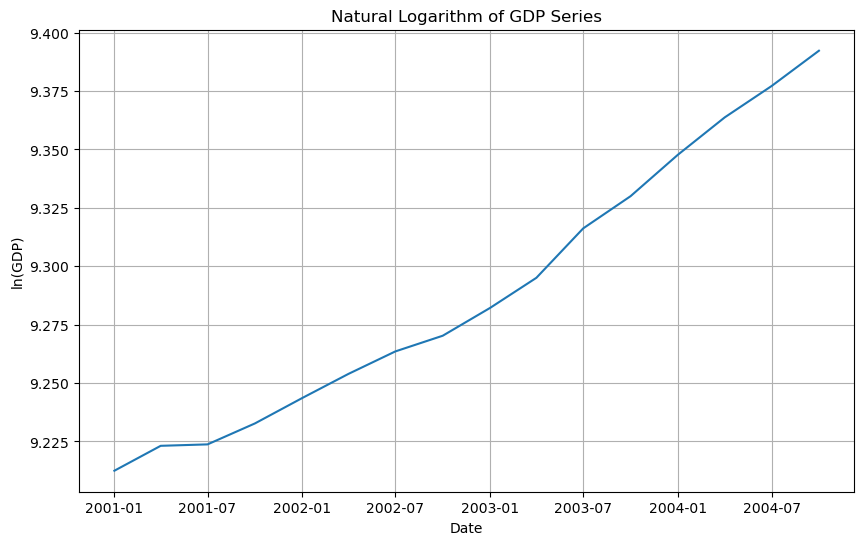

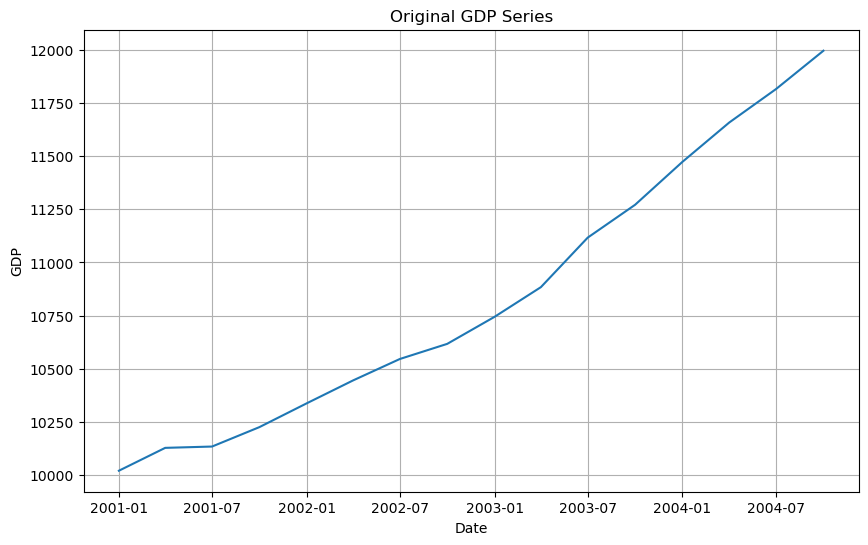

In [41]:
# Plot natural logarithm of GDP series
plt.figure(figsize=(10, 6))
plt.plot(nominalGDP['ln_GDP'])
plt.title('Natural Logarithm of GDP Series')
plt.xlabel('Date')
plt.ylabel('ln(GDP)')
plt.grid(True)
plt.show()

# Plot original GDP series
plt.figure(figsize=(10, 6))
plt.plot(nominalGDP['GDP'])
plt.title('Original GDP Series')
plt.xlabel('Date')
plt.ylabel('GDP')
plt.grid(True)
plt.show()

## We cannot compare the 2 series since the plots' scales are different. As such, I further plot the g1t and g2t on the same chart.

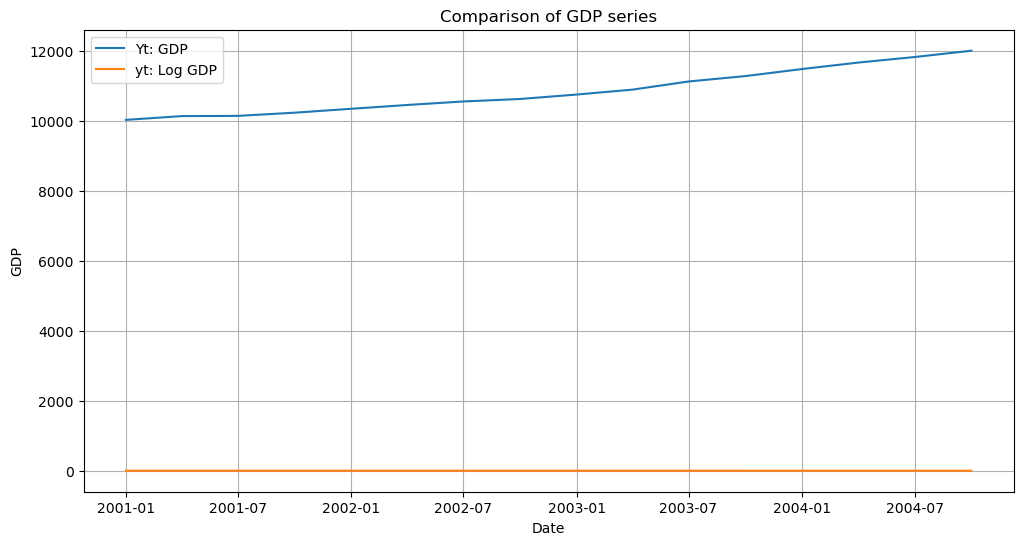

In [42]:
# Plot Yt and yt on the same chart
plt.figure(figsize=(12, 6))
plt.plot(nominalGDP['GDP'], label='Yt: GDP')
plt.plot(nominalGDP['ln_GDP'], label='yt: Log GDP')
plt.title('Comparison of GDP series')
plt.xlabel('Date')
plt.ylabel('GDP')
plt.legend()
plt.grid(True)
plt.show()


##  Stationary: The yt series appears to be more stationary compared to the original Yt series, with less visible trends or seasonality. This suggests that taking the natural logarithm of the GDP series may help reduce the non-stationarity present in the original GDP series.

## Smoothness: The yt series appears to be smoother compared to the original Yt series. This is because taking the natural logarithm can help stabilize and compress the scale of the data, reducing extreme fluctuations and making the series appear smoother.

## d)

In [43]:
nominalGDP['lag_ln_GDP'] = nominalGDP['ln_GDP'].shift()

In [44]:
nominalGDP['Growth_rate_log'] = 100*(nominalGDP['ln_GDP'] - nominalGDP['lag_ln_GDP'])
nominalGDP.Growth_rate_log

Date
2001-01-01         NaN
2001-04-01    1.065994
2001-07-01    0.061192
2001-10-01    0.895819
2002-01-01    1.088294
2002-04-01    1.034464
2002-07-01    0.960364
2002-10-01    0.670953
2003-01-01    1.189972
2003-04-01    1.289052
2003-07-01    2.115466
2003-10-01    1.377570
2004-01-01    1.773740
2004-04-01    1.598817
2004-07-01    1.341170
2004-10-01    1.511178
Name: Growth_rate_log, dtype: float64

In [45]:
nominalGDP.Growth_rate

Date
2001-01-01         NaN
2001-04-01    1.071696
2001-07-01    0.061211
2001-10-01    0.899843
2002-01-01    1.094237
2002-04-01    1.039833
2002-07-01    0.964990
2002-10-01    0.673209
2003-01-01    1.197080
2003-04-01    1.297396
2003-07-01    2.138001
2003-10-01    1.387102
2004-01-01    1.789564
2004-04-01    1.611666
2004-07-01    1.350204
2004-10-01    1.522654
Name: Growth_rate, dtype: float64

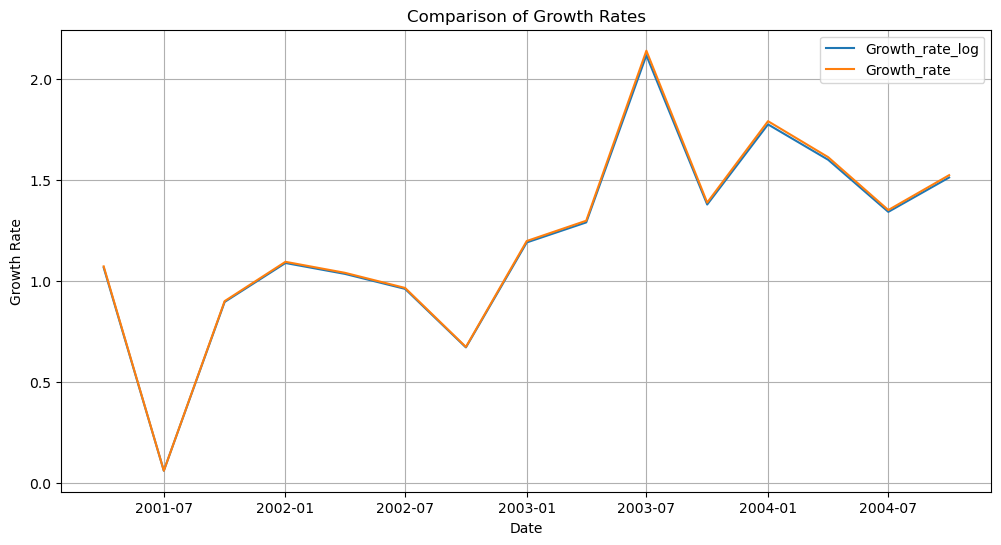

In [46]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot nominalGDP.Growth_rate_log series
ax.plot(nominalGDP.Growth_rate_log.index, nominalGDP.Growth_rate_log.values, label='Growth_rate_log')

# Plot nominalGDP.Growth_rate series
ax.plot(nominalGDP.Growth_rate.index, nominalGDP.Growth_rate.values, label='Growth_rate')

# Set labels and title
ax.set_title('Comparison of Growth Rates')
ax.set_xlabel('Date')
ax.set_ylabel('Growth Rate')
ax.legend()  # Add legend
ax.grid(True)

# Show the plot
plt.show()

## By visually comparing the lines, there is no significant differences between the two growth rate series.